# Assignment 1
## Problem 1 - System Identification

In [1]:
%reload_ext autoreload
#%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

# from src.models.mls_models import MyFancyModel
# from rbf_mlp import RbfNetwork
from src.utils.plotting import init_plot_style
#%pylab
%matplotlib inline  

init_plot_style()
data_dir='../../data/csv/1_1_system_identification/'

warnings.filterwarnings('ignore') # Supress warnings from polyfit

First, let's take a look at the training and test data.

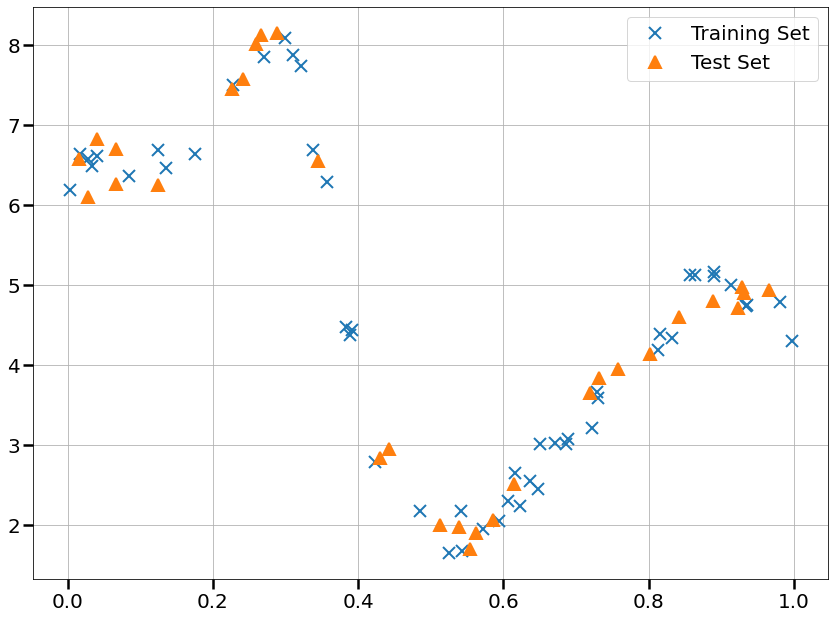

In [2]:
training_set = pd.read_csv(data_dir + 'training-set.csv').to_numpy()
x_train, y_train = training_set[:,0], training_set[:,1]

test_set = pd.read_csv(data_dir + 'test-set.csv').to_numpy()
x_test, y_test = test_set[:,0], test_set[:,1]

plt.close('all')
plt.figure()
plt.plot(x_train, y_train, 'x', label='Training Set')
plt.plot(x_test, y_test, '^', label='Test Set')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Run your experiments from here on!

**Defenition of some functions for Task 1**

In [3]:
#Compute the MSE of the given coefficents p

def MSE(p,x,y):
        """Computing the 1D-MSE, given the polynomial coefficents p, the places x and the data y  """
        y_hat = np.polyval(p,x) 
        error = (y_hat-y)**2    
        mse = np.mean(error)
        return mse
    
    
# Evaluate the polynomial model
    
def PolyModelEval(order, x_fit, y_fit, x):
        """Evaluate the poly model, fited to the data [x_fit, y_fit] at x"""
        p = np.polyfit(x_fit, y_fit, order, full=False)
        y_hat = np.polyval(p,x)
        return y_hat
    
# For RBF linear least squares solution

def RbfOptimizer(P, w, x):
        """Compute the matrix A for finding the linear least squares solution based on the data x."""
        rbf_center = np.arange(0,1,1/P)
        A = np.ones([np.size(x), P])
        
        for i in range(0,np.size(x)):
            for j in range(1,P):
                A[i,j] = np.exp(1)**(-(x[i]-rbf_center[j])**2/w)
        return A
    

<hr style='border:2.2px solid Black'></hr>

**Task a)** Find a suitable polynomial model using the test set.

In [4]:
#First test just with polyfit

P_max = 25
residuals_train = np.zeros(P_max-1)
residuals_test = np.zeros(P_max-1)

for order in range(1,P_max):
    
    p = np.polyfit(x_train, y_train, order, full=False)
    residuals_train[order-1] = MSE(p,x_train, y_train)
    residuals_test[order-1] = MSE(p,x_test, y_test)
    
train_min = np.where(residuals_train == np.amin(residuals_train)) #optimal order
test_min = np.where(residuals_test == np.amin(residuals_test))    #optimal order


Visual inspection of the results:

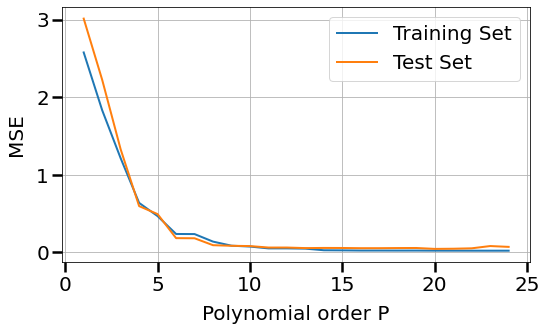

Optimal polynomial order for training set:  [23] with MSE:  [0.02241836]
Optimal polynomial order for test set:  [20] with MSE:  [0.04568998]


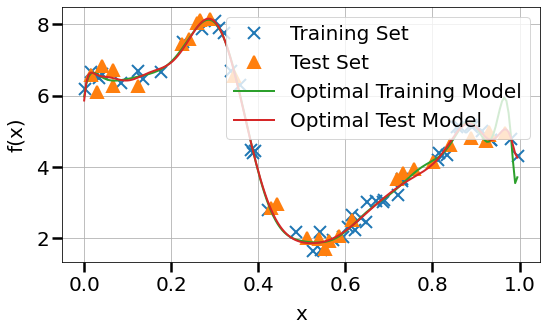

In [5]:
#Plot of MSE for train and test

plt.figure(figsize=(8,5))
plt.plot(np.arange(1,P_max),residuals_train, label='Training Set')
plt.plot(np.arange(1,P_max), residuals_test, label='Test Set')
plt.legend()
plt.xlabel('Polynomial order P')
plt.ylabel('MSE')
plt.grid()
plt.tight_layout()
plt.show()

print('Optimal polynomial order for training set: ', train_min[0]+1, 'with MSE: ', residuals_train[train_min[0]])
print('Optimal polynomial order for test set: ', test_min[0]+1, 'with MSE: ', residuals_test[test_min[0]])

#Plot the optimal model with training/test set

x_eval = np.arange(0,1,0.005)
opt_train_model = PolyModelEval(train_min[0]+1, x_train, y_train, x_eval)
opt_test_model = PolyModelEval(test_min[0]+1, x_train, y_train, x_eval)

plt.figure(figsize=(8,5))
plt.plot(x_train, y_train, 'x', label='Training Set')
plt.plot(x_test, y_test, '^', label='Test Set')
plt.plot(x_eval, opt_train_model, label='Optimal Training Model')
plt.plot(x_eval, opt_test_model, label='Optimal Test Model')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

<hr style='border:2.2px solid Black'></hr>

**Task b)** Use a subset of the original training set as validation set. Training and validation set must be disjoint.

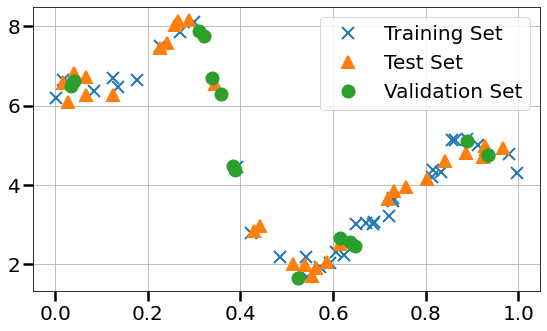

In [6]:
TV_ratio = 0.3 #Define splitting ratio btw. training and validation set, in [0,1]

N_sample = np.size(x_train)
Val_size = np.ceil(N_sample*TV_ratio)

rng = np.random.default_rng(7) #seed value set!!!
pos = rng.choice(N_sample,Val_size.astype(int), replace=False) #Draw non-repetitive random numbers

x_validation = x_train[pos]
y_validation = y_train[pos]

x_train2 = np.delete(x_train, pos)
y_train2 = np.delete(y_train, pos)

# Plot the splitted data-set
plt.figure(figsize=(8,5))
plt.plot(x_train2, y_train2, 'x', label='Training Set')
plt.plot(x_test, y_test, '^', label='Test Set')
plt.plot(x_validation, y_validation, 'o', label='Validation Set')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Evaluation based on validation set performance:

In [7]:
P_max = 30

residuals_validation = np.zeros(P_max-1)
residuals_train = np.zeros(P_max-1)
residuals_test = np.zeros(P_max-1)

for order in range(1,P_max):
    
    p = np.polyfit(x_train2, y_train2, order, full=False)
    residuals_train[order-1] = MSE(p,x_train2, y_train2)
    residuals_validation[order-1] = MSE(p,x_validation, y_validation)
    residuals_test[order-1] = MSE(p,x_test, y_test)
    
validation_min = np.where(residuals_validation == np.amin(residuals_validation)) #optimal order
test_min = np.where(residuals_test == np.amin(residuals_test))

print('Optimal polynomial order for validation set: ', validation_min[0]+1, 'with MSE: ', residuals_validation[validation_min[0]])
print('Optimal polynomial order for test set: ', test_min[0]+1, 'with MSE: ', residuals_test[test_min[0]])

Optimal polynomial order for validation set:  [21] with MSE:  [0.03892393]
Optimal polynomial order for test set:  [21] with MSE:  [0.05241151]


Visual inspection of the results:

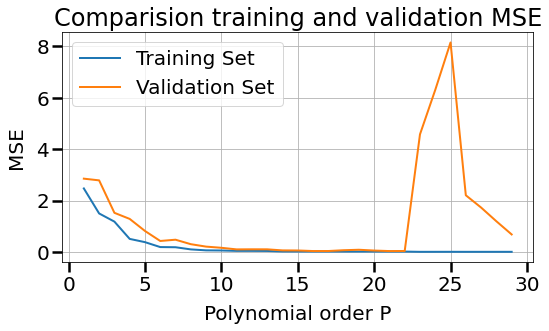

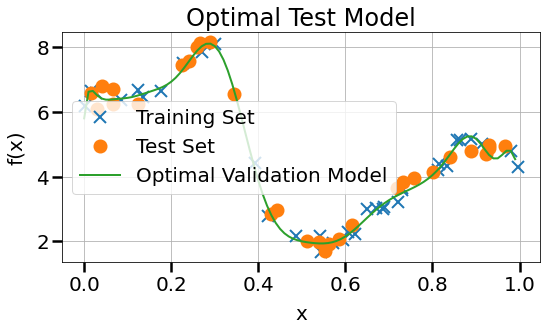

In [8]:
#Plot the training and validation MSE curve

plt.close('all')
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,P_max),residuals_train, label='Training Set')
plt.plot(np.arange(1,P_max), residuals_validation, label='Validation Set')
plt.xlabel('Polynomial order P')
plt.ylabel('MSE')
plt.title('Comparision training and validation MSE')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

#Plot of the optimal model based on test set

x_eval = np.arange(0,1,0.01)
y_opt_model = PolyModelEval(validation_min[0]+1, x_train2, y_train2, x_eval)

plt.figure(figsize=(8,5))
plt.plot(x_train2, y_train2, 'x', label='Training Set')
plt.plot(x_test, y_test, 'o', label='Test Set')
plt.plot(x_eval, y_opt_model, label='Optimal Validation Model')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Optimal Test Model')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

&ensp;
<hr style='border:2.2px solid Black'></hr>

**Task c)** Use a Gaussian radial basis ($RBF$) function model $\hat{f}$

$\hat{f}(x) = \alpha_0 + \sum_{p=1}^{P} \alpha_p e^{\frac{-(x-c_p)^2}{2\omega_p^2}}$

To avoid the nonlinearity, the centers of the P $RBF$ are choosen evenly spaced on the support of the given data.

The coefficent vector $c_{opt}$ is determined by means of minimizing the MSE for thge given model oder P:

$
c_{opt} = (A^TA)^{-1} \cdot A^T y_{train}
$

Where $A$ is defined as:
&ensp;

$
A = \begin{bmatrix}
1 & e^{\frac{-(x[0]-c_1)^2}{2\omega^2}} & e^{\frac{-(x[1]-c_1)^2}{2\omega^2}} & \dots & e^{\frac{-(x[N]-c_1)^2}{2\omega^2}}\\
1 & e^{\frac{-(x[0]-c_2)^2}{2\omega^2}} & e^{\frac{-(x[1]-c_2)^2}{2\omega^2}} & \dots & e^{\frac{-(x[N]-c_2)^2}{2\omega^2}}\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
1 & e^{\frac{-(x[0]-c_P)^2}{2\omega^2}} & e^{\frac{-(x[1]-c_P)^2}{2\omega^2}} & \dots &  e^{\frac{-(x[N]-c_P)^2}{2\omega^2}}
\end{bmatrix}
$

&ensp;
&ensp;
&ensp;
&ensp;

MSE on test set:  0.04439075617460967


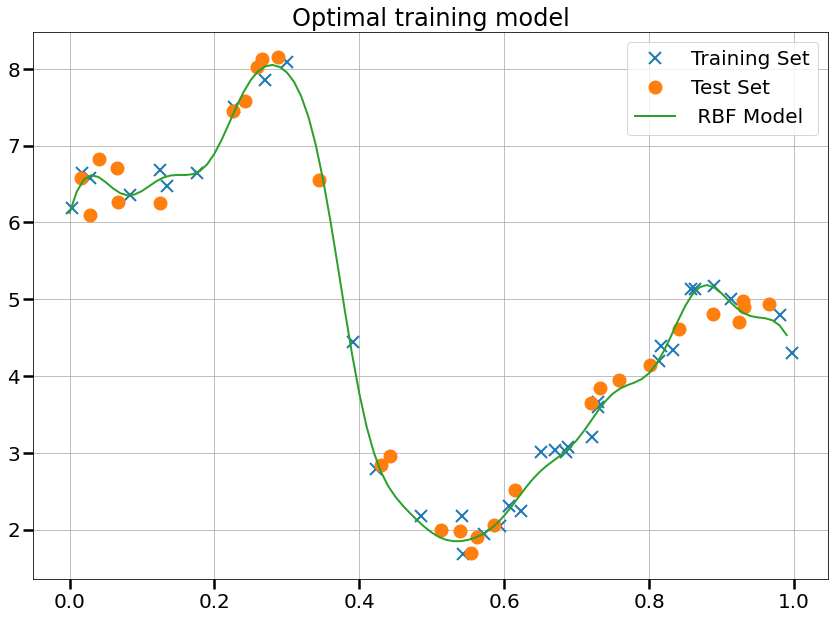

In [9]:
P = 20 #number of RBF's

rbf_center = np.arange(0,1,1/P)
w2 = (2/P)**2 #width parameter sqared

A = RbfOptimizer(P, w2, x_train)     
c_opt = np.linalg.pinv(A).dot(y_train)

#Evaluate the model with test set

y_hat = RbfOptimizer(P, w2, x_test).dot(c_opt)  #for MSE compuation
mse = np.mean((y_hat-y_test)**2)  

print('MSE on test set: ', mse)

x_eval = np.arange(0,1,0.01)
y_eval = RbfOptimizer(P, w2, x_eval).dot(c_opt) #for plot

#Plot the model for the selected model order P

plt.figure()
plt.plot(x_train2, y_train2, 'x', label = 'Training Set')
plt.plot(x_test, y_test, 'o', label='Test Set')
plt.plot(x_eval, y_eval, label = ' RBF Model')
plt.title('Optimal training model')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Optimal RBF order for test set:  [20] with MSE:  [[0.04439076]]


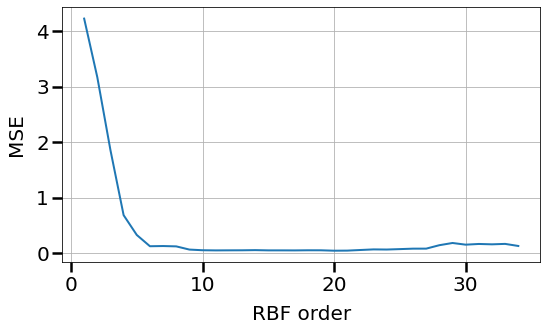

In [10]:
#Just some code to find the optimal model order P, not asked!
P = 35 #number of RBF's

mse = np.zeros([P-1,1])

for order in range(1,P):
    
    w2 = (2/order)**2                    #width parameter sqared
    rbf_center = np.arange(0,1,1/order)  #RBF centers
    
    A = RbfOptimizer(order, w2, x_train)     
    c_opt = np.linalg.pinv(A).dot(y_train)
    
    y_hat = RbfOptimizer(order, w2, x_test).dot(c_opt)
    mse[order-1] = np.mean((y_hat-y_test)**2)  
    
mse_min = np.where(mse == np.amin(mse)) #optimal order
print('Optimal RBF order for test set: ', mse_min[0]+1, 'with MSE: ', mse[mse_min[0]])

plt.figure(figsize=(8,5))
plt.plot(np.arange(1,P,1), mse)
plt.xlabel('RBF order')
plt.ylabel('MSE')
plt.grid()
plt.tight_layout()


&ensp;

<hr style='border:2.2px solid Black'></hr>

**Task d)** Learn the optimal centers and widths using gradient descent (GD) applyed on a RBF-NN. 

Epoch 0 training loss is 5.11
Epoch 50 training loss is 0.19
Epoch 100 training loss is 0.05
Epoch 150 training loss is 0.05
Epoch 200 training loss is 0.04
Epoch 250 training loss is 0.06


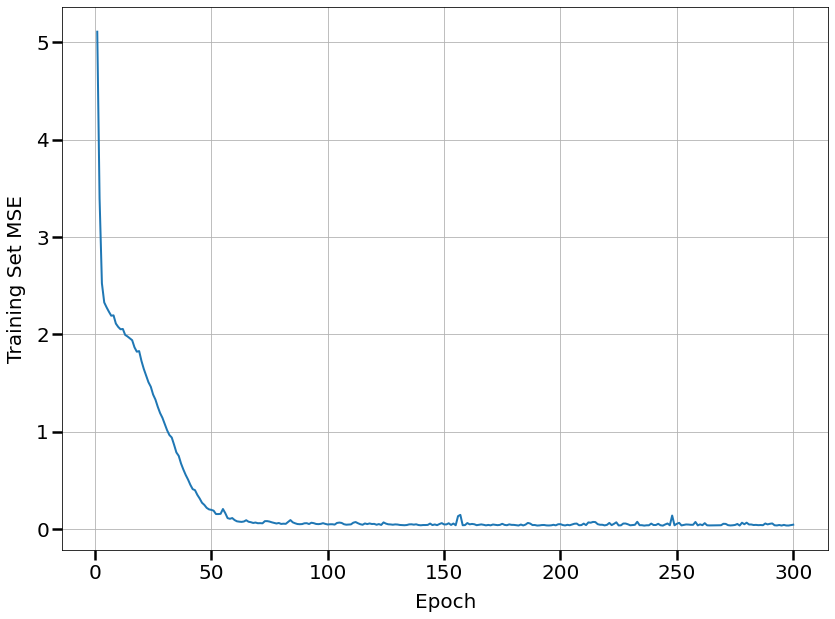

In [11]:
from src.models.rbf_mlp import RbfMLP

rbf_mlp_model = RbfMLP(hidden_size = 20)
loss_list = rbf_mlp_model.fit(x_train, y_train)

plt.figure()
plt.plot(list(range(1, 1 + len(loss_list))), loss_list)
plt.xlabel('Epoch')
plt.ylabel('Training Set MSE')
plt.grid()
plt.tight_layout()

Training MSE is 0.0453
Test MSE is 0.0539


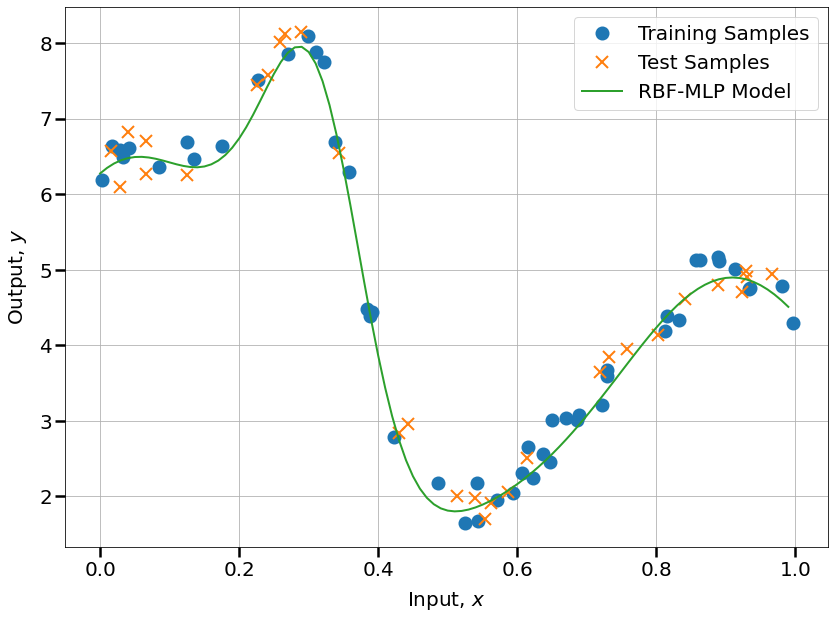

In [12]:
x_eval = np.arange(0,1,0.01)

approx_output = rbf_mlp_model.predict(x_eval)
y_pred = rbf_mlp_model.predict(x_test)

print(f'Training MSE is {loss_list[-1]:.4f}')
print(f'Test MSE is {np.mean((y_test-np.transpose(y_pred))**2):.4f}')

plt.figure()
plt.plot(x_train, y_train, 'o', label='Training Samples')
plt.plot(x_test, y_test, 'x', label='Test Samples')
plt.plot(x_eval, approx_output, label='RBF-MLP Model')
#plt.plot(x_eval, y_eval, label = 'Static RBF Model')
plt.xlabel('Input, $x$')
plt.ylabel('Output, $y$')
plt.legend()
plt.grid()
plt.tight_layout()

&ensp;

<hr style='border:2.2px solid Black'></hr>

**Task e)** Approximation using a feed-foward neuronal network. 

Epoch 0 training loss is 3.56
Epoch 50 training loss is 2.35
Epoch 100 training loss is 2.29
Epoch 150 training loss is 2.15
Epoch 200 training loss is 1.73
Epoch 250 training loss is 0.36
Training MSE is 0.1298s is 0.13
Test MSE is 0.0815


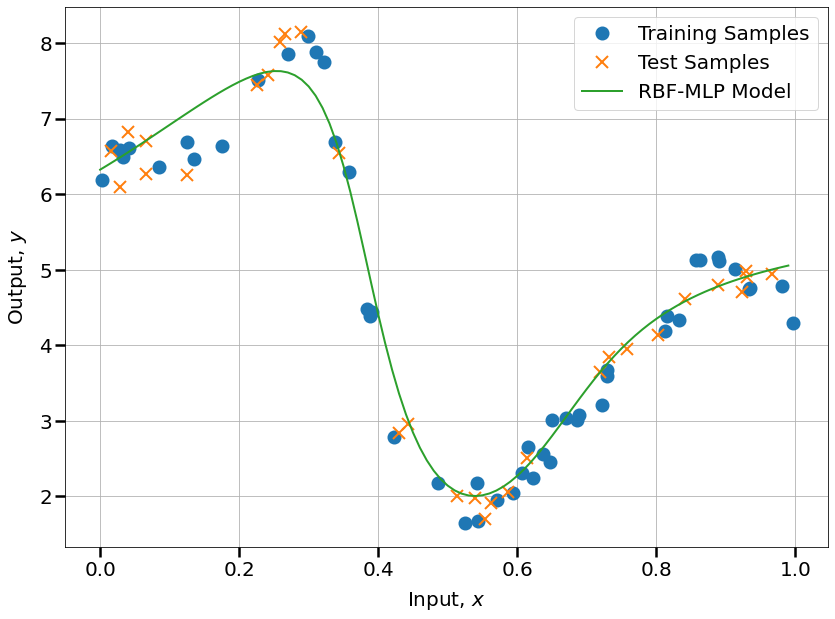

In [27]:
from src.models.variable_rbf_mlp import VarRbfMLP

h_list = [25,200,200] #creates a 4 layer MLP with 20 neurons per layer

rbf_mlp_model = VarRbfMLP(h_sizes = h_list)
loss_list = rbf_mlp_model.fit(x_train, y_train, batch_size=15
                              , learning_rate=1e-2, max_epochs=300)

x_eval = np.arange(0,1,0.01)

approx_output = rbf_mlp_model.predict(x_eval)
y_pred = rbf_mlp_model.predict(x_test)

print(f'Training MSE is {loss_list[-1]:.4f}')
print(f'Test MSE is {np.mean((y_test-np.transpose(y_pred))**2):.4f}')

plt.figure()
plt.plot(x_train, y_train, 'o', label='Training Samples')
plt.plot(x_test, y_test, 'x', label='Test Samples')
plt.plot(x_eval, approx_output, label='RBF-MLP Model')
#plt.plot(x_eval, y_eval, label = 'Static RBF Model')
plt.xlabel('Input, $x$')
plt.ylabel('Output, $y$')
plt.legend()
plt.grid()
plt.tight_layout()